<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/2FFNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

for i in range(10):
    batch = train_generator.next()

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model FFNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons1 = 548
hidden_neurons2 = 74

model2f = Sequential()
model2f.add(Flatten(input_shape=(52, 78, 1)))
model2f.add(Dense(hidden_neurons1, activation='relu'))
model2f.add(Dense(hidden_neurons2, activation='relu'))
model2f.add(Dense(10, activation='softmax'))

model2f.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Mendapatkan bobot dari model
weights = []
for layer in model2f.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
Layer 2
  Bobot 1: (4056, 548)
  Bobot 2: (548,)
Layer 3
  Bobot 1: (548, 74)
  Bobot 2: (74,)
Layer 4
  Bobot 1: (74, 10)
  Bobot 2: (10,)


In [9]:
model2f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4056)              0         
                                                                 
 dense (Dense)               (None, 548)               2223236   
                                                                 
 dense_1 (Dense)             (None, 74)                40626     
                                                                 
 dense_2 (Dense)             (None, 10)                750       
                                                                 
Total params: 2264612 (8.64 MB)
Trainable params: 2264612 (8.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = model2f.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 3s 82ms/step - loss: 2.0542 - accuracy: 0.2842
Epoch 2/20
28/28 [==============================] - 2s 82ms/step - loss: 1.9569 - accuracy: 0.3426
Epoch 3/20
28/28 [==============================] - 2s 81ms/step - loss: 1.9143 - accuracy: 0.3766
Epoch 4/20
28/28 [==============================] - 3s 121ms/step - loss: 1.8980 - accuracy: 0.3755
Epoch 5/20
28/28 [==============================] - 2s 82ms/step - loss: 1.8806 - accuracy: 0.3925
Epoch 6/20
28/28 [==============================] - 3s 115ms/step - loss: 1.8560 - accuracy: 0.3783
Epoch 7/20
28/28 [==============================] - 3s 103ms/step - loss: 1.8236 - accuracy: 0.3999
Epoch 8/20
28/28 [==============================] - 4s 132ms/step - loss: 1.7917 - accuracy: 0.3999
Epoch 9/20
28/28 [==============================] - 4s 145ms/step - loss: 1.7820 - accuracy: 0.4084
Epoch 10/20
28/28 [==============================] - 4s 146ms/step - loss: 1.7661 - accuracy: 0.4118
Epo

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Inisialisasi dictionary untuk menyimpan bobot dan bias dari setiap layer
weights_biases = {}

# Loop melalui semua layer dalam model yang sudah dimuat
for layer in model2f.layers:
    # Periksa apakah layer adalah lapisan Dense
    if isinstance(layer, Dense):
        # Periksa apakah layer memiliki bobot dan bias
        if layer.get_weights():
            # Peroleh bobot dari lapisan
            weights, biases = layer.get_weights()
            # Simpan bobot dan bias dalam dictionary dengan menggunakan nama layer
            weights_biases[layer.name] = {'weights': weights, 'biases': biases}

# Loop melalui semua layer dalam model dan cetak informasi tentang bobot dan bias
for layer_name, params in weights_biases.items():
    print(f"Layer Name: {layer_name}")
    print("Weight Matrix Shape:", params['weights'].shape)  # Ukuran matriks bobot
    print("Weight Matrix:")
    print(params['weights'])  # Bobot
    print("Bias Vector Shape:", params['biases'].shape)    # Ukuran vektor bias
    print("Bias Vector:")
    print(params['biases'])    # Bias
    print("-----------------------------------")

Layer Name: dense
Weight Matrix Shape: (4056, 548)
Weight Matrix:
[[-0.01763511 -0.03427899  0.00233273 ...  0.00592832  0.02317305
  -0.01692135]
 [-0.0173535   0.00819903  0.00935535 ... -0.0341442  -0.03312663
   0.00957693]
 [-0.02146533 -0.01187791  0.02609757 ...  0.03294631 -0.02532249
   0.00175028]
 ...
 [-0.01547512 -0.02428358  0.02463515 ... -0.03367705 -0.00368449
   0.01998477]
 [-0.01227813  0.00438002  0.0159093  ...  0.03219128 -0.01255791
  -0.00810268]
 [-0.00320256  0.00498865  0.01367119 ... -0.00655162 -0.02926035
  -0.01095653]]
Bias Vector Shape: (548,)
Bias Vector:
[ 2.44677672e-03  3.80552781e-04 -1.86935693e-04 -1.89484621e-03
  2.78782652e-04 -1.59446546e-03 -3.39462585e-03  0.00000000e+00
  2.00289069e-03 -4.06556705e-04 -7.04882317e-04 -5.72954654e-04
 -7.34378526e-04  2.15997643e-04 -4.41302836e-04 -7.08833395e-04
 -3.09185816e-06 -5.04442258e-03 -6.58166711e-04  1.16849667e-03
  1.51182152e-03  1.41468830e-03 -6.72864553e-04  1.10840460e-03
 -7.07476807e

In [15]:
from google.colab import files
import cv2

import numpy as np

# Fungsi aktivasi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fungsi softmax
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

# Fungsi forward pass manual
def manual_forward_pass(X, weights_biases):
    # Hidden layer 1 input (Z1)
    hidden_layer1_input = np.dot(X, weights_biases['dense']['weights']) + weights_biases['dense']['biases']
    # Hidden layer 1 output (A1)
    hidden_layer1_output = sigmoid(hidden_layer1_input)

    # Hidden layer 2 input (Z2)
    hidden_layer2_input = np.dot(hidden_layer1_output, weights_biases['dense_1']['weights']) + weights_biases['dense_1']['biases']
    # Hidden layer 2 output (A2)
    hidden_layer2_output = sigmoid(hidden_layer2_input)

    # Output layer input (Z3)
    output_layer_input = np.dot(hidden_layer2_output, weights_biases['dense_2']['weights']) + weights_biases['dense_2']['biases']
    # Output layer output (A3)
    output_layer_output = softmax(output_layer_input)

    return hidden_layer1_input, hidden_layer1_output, hidden_layer2_input, hidden_layer2_output, output_layer_input, output_layer_output

# Fungsi untuk mengunggah gambar
uploaded = files.upload()

# Baca gambar yang diunggah
for fn in uploaded.keys():
    # Baca gambar menggunakan OpenCV
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)  # Ubah ke skala keabuan (grayscale) jika perlu
    # Lakukan pra-pemrosesan, seperti resize gambar ke ukuran yang sesuai dengan model Anda
    img_resized = cv2.resize(img, (78, 52))  # Sesuaikan ukuran dengan kebutuhan model Anda

# Ubah gambar menjadi array numpy dan lakukan normalisasi jika diperlukan
X_test_sample = np.array(img_resized).reshape(1, -1)
X_test_sample = X_test_sample / 255.0  # Normalisasi

# Lakukan feedforward untuk mendapatkan prediksi
hidden_layer1_input, hidden_layer1_output, hidden_layer2_input, hidden_layer2_output, output_layer_input, output_layer_output = manual_forward_pass(X_test_sample, weights_biases)

# Lakukan prediksi dengan mengambil kelas dengan nilai probabilitas tertinggi
predicted_class = np.argmax(output_layer_output)

# Tampilkan prediksi
print("Predicted Class:", predicted_class)

Saving 20231206_091207.jpg to 20231206_091207 (1).jpg
Predicted Class: 3


In [17]:
print("Input Hidden Layer 1 :")
print(hidden_layer1_input)
print("Output Hidden Layer 1 :")
print(hidden_layer1_output)
print("Input Hidden Layer 2 :")
print(hidden_layer2_input)
print("Input Hidden Layer 2 :")
print(hidden_layer2_input)
print("Input Layer Output :")
print(output_layer_input)
print("Output Layer Output :")
print(output_layer_output)

Input Hidden Layer 1 :
[[ 9.59341316e-01 -3.99393528e-01 -8.62729446e-01  1.09004391e+00
  -4.60401050e-01  9.24058247e-01 -1.12052503e-01 -1.02658890e+00
  -2.83476916e-01 -7.66424098e-01 -8.05754925e-01 -9.12720920e-01
   2.92769616e-01 -2.39951993e-01 -7.20949961e-01 -7.97293468e-01
  -1.16652297e+00  6.91880069e-01  4.31650042e-01  4.66535228e-01
   1.96593464e-01 -1.12650943e-02 -7.80869414e-01  4.38978264e-01
  -3.90373352e-01  3.90806782e-01 -8.69474104e-01  2.73663839e-02
  -1.05323067e+00  1.23491786e-01  8.98920883e-01 -1.91594055e+00
   6.75064567e-02 -6.31764582e-01  1.27302981e+00 -2.92926206e-02
   2.30820054e-01 -6.94974347e-01  6.92919804e-02  1.44676970e-02
  -6.09828441e-02  1.68020897e-01  3.70809041e-01 -1.32673965e-01
  -1.47144420e-01 -5.71814603e-01  8.06651850e-01  5.62181108e-02
   4.81594321e-02 -8.89442653e-01  1.34871936e-01  1.82758925e-01
   6.51896860e-02 -1.16790696e-02 -2.79850954e-01 -1.54349952e+00
   3.45447501e-01  2.17045150e-01  5.47228140e-01 -1.

#Matriks Konfusi

7/7 [==============================] - 0s 39ms/step


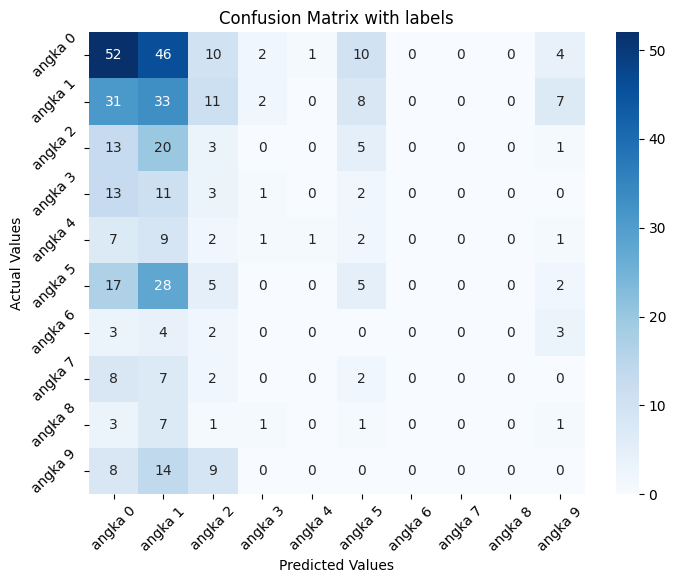

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model2f, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [31]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.21348314606741572
